In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

In [84]:
rs=121
ns=5
stocks=['aapl']
testing_size=500
tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
spread_range = range(2, 25)

In [94]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/merged_stock_data.csv',engine='python')
data1=pd.read_csv(init_dir_path+'/stock_hmm_output_kalman.csv',engine='python')

features=['Return','HighR','LowR','Volatility']
data_features=pd.read_csv(init_dir_path+'/stock_hmm_output.csv',engine='python').drop(['Unnamed: 0'],axis=1)
#features=['Smooth_'+x for x in features]+['Volatility','Smooth_Volume']
target='state'

In [95]:
data[features]=data_features[features]
features.append('sentiment_score')
data=data[data['ticker']=='aapl']

In [96]:
data=data[-2100:-5].drop(['unnamed: 0'],axis=1)

In [97]:
data=data.reset_index(drop=True)

In [98]:
data.fillna(0,inplace=True)

In [99]:
ft_size=395
final_test=data[-ft_size:]
stocks_data=data[:-ft_size]

In [100]:
def create_sliding_window(train_df, test_df, features, target, window=7):
    splitter = SlidingWindowSplitter(window_length=window, step_length=1, fh=[1])
    train_x, train_y, test_x, test_y = [], [], [], []

    for idx in splitter.split(train_df):
        X = train_df.iloc[idx[0]][features].values.flatten()
        y = train_df.iloc[idx[1]][target].values.flatten()[0]
        train_x.append(X)
        train_y.append(y)

    for idx in splitter.split(test_df):
        X = test_df.iloc[idx[0]][features].values.flatten()
        y = test_df.iloc[idx[1]][target].values.flatten()[0]
        test_x.append(X)
        test_y.append(y)

    return (train_x, train_y), (test_x, test_y)

In [101]:
testing_size=200
ns=5
tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
spread_range = range(5, 20)

In [102]:
training_lists = {}
testing_lists = {}
for spread in spread_range:
    ticker_df=stocks_data
    training_list = [[[], []] for _ in range(ns)]
    testing_list = [[[], []] for _ in range(ns)]
    for fold_idx, (train_idx, test_idx) in enumerate(tss.split(ticker_df)):
        train_df = ticker_df.iloc[train_idx]
        test_df = ticker_df.iloc[test_idx]           
        (train_x, train_y), (test_x, test_y) = create_sliding_window(train_df, test_df, features, target, window=spread)
        training_list[fold_idx][0] += train_x
        training_list[fold_idx][1] += train_y
        testing_list[fold_idx][0] += test_x
        testing_list[fold_idx][1] += test_y
    training_lists[spread] = training_list
    testing_lists[spread] = testing_list #spread->stock index->time series split->data/label

In [72]:
with open('saved_training_lists_sentiment_aapl', 'wb') as f:
    pickle.dump(training_lists, f)

with open('saved_testing_lists_sentiment_aapl', 'wb') as f:
    pickle.dump(testing_lists, f)

In [77]:
def accuracies_model(model_dict, window, map=False):
    a=0
    conf_mat=np.zeros((2,2))
    y_true_all=[]
    y_pred_all=[]
    if map:
        model = model_dict[window]
    else:
        model = model_dict
    for i in range(ns):
        model.fit(X=training_lists[window][i][0],y=training_lists[window][i][1])
        y_pred=model.predict(testing_lists[window][i][0])
        y_true=testing_lists[window][i][1]
        a+= accuracy_score(y_true,y_pred)
        y_true_all=y_true_all+list(y_true)
        y_pred_all=y_pred_all+list(y_pred)
    conf_mat=confusion_matrix(y_true=y_true_all,y_pred=y_pred_all)
    a=a/ns
    return (a,conf_mat)

In [81]:
def plot_accuracies(accuracies, model_type, acc_type="accuracy"): #accuracies needs to be a nested dictionary window->stock index
    vals = []
    for window in accuracies.keys():
        vals.append(accuracies[window])
    plt.figure(figsize=(6, 4))
    plt.plot(list(accuracies.keys()), vals, marker='o')
    plt.title(f"{model_type} accuracy scores for {stocks[0]}")
    plt.xlabel("Window size")
    plt.ylabel(acc_type)
    plt.tight_layout()
    plt.show()

In [103]:
accuracies_ada = {}
confusion_mat = {}
f1_score={}
ada_model = AdaBoostClassifier(n_estimators=110,random_state=121)
for window in spread_range:
    results=accuracies_model(ada_model,window)
    accuracies_ada[window] = results[0]
    confusion_mat[window] = results[1]
    A=confusion_mat[window]
    f1_score[window]=(2*A[0][0]/(2*A[0][0]+A[0][1]+A[1][0]))

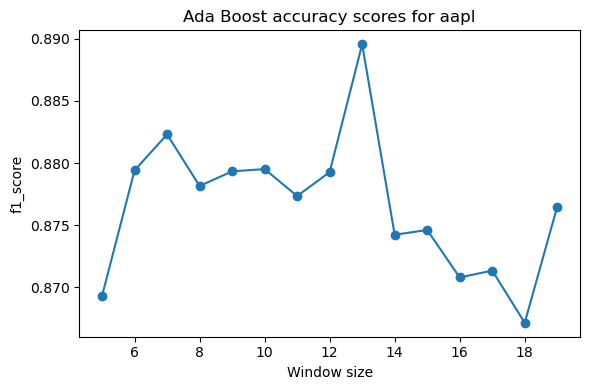

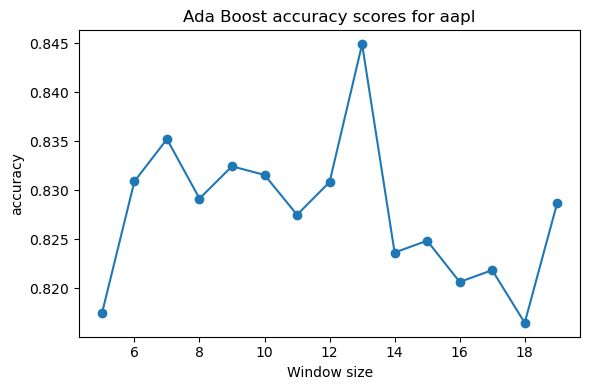

In [106]:
plot_accuracies(f1_score, "Ada Boost",acc_type="f1_score")
plot_accuracies(accuracies_ada, "Ada Boost")

In [104]:
features.remove('sentiment_score')

In [105]:
training_lists = {}
testing_lists = {}
for spread in spread_range:
    ticker_df=stocks_data
    training_list = [[[], []] for _ in range(ns)]
    testing_list = [[[], []] for _ in range(ns)]
    for fold_idx, (train_idx, test_idx) in enumerate(tss.split(ticker_df)):
        train_df = ticker_df.iloc[train_idx]
        test_df = ticker_df.iloc[test_idx]           
        (train_x, train_y), (test_x, test_y) = create_sliding_window(train_df, test_df, features, target, window=spread)
        training_list[fold_idx][0] += train_x
        training_list[fold_idx][1] += train_y
        testing_list[fold_idx][0] += test_x
        testing_list[fold_idx][1] += test_y
    training_lists[spread] = training_list
    testing_lists[spread] = testing_list #spread->stock index->time series split->data/label

In [107]:
accuracies_ada = {}
confusion_mat = {}
f1_score={}
ada_model = AdaBoostClassifier(n_estimators=110,random_state=121)
for window in spread_range:
    results=accuracies_model(ada_model,window)
    accuracies_ada[window] = results[0]
    confusion_mat[window] = results[1]
    A=confusion_mat[window]
    f1_score[window]=(2*A[0][0]/(2*A[0][0]+A[0][1]+A[1][0]))

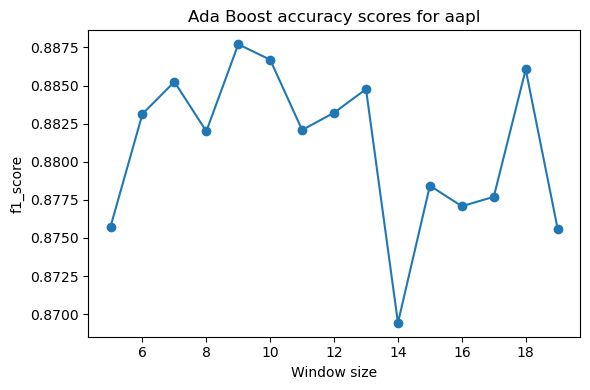

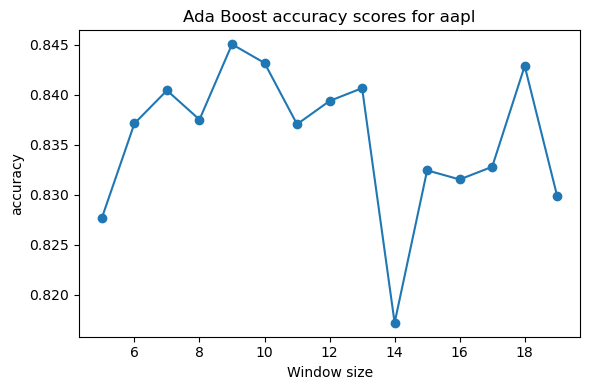

In [108]:
plot_accuracies(f1_score, "Ada Boost",acc_type="f1_score")
plot_accuracies(accuracies_ada, "Ada Boost")